In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

### Importing the Datasets

In [2]:
df = pd.read_csv("tesla-stock-price.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    756 non-null    object 
 1   close   756 non-null    float64
 2   volume  756 non-null    float64
 3   open    756 non-null    float64
 4   high    756 non-null    float64
 5   low     756 non-null    float64
dtypes: float64(5), object(1)
memory usage: 35.6+ KB


### Cleaning the Data

Removing null and duplicate values

In [3]:
df.dropna(inplace=True)
df.drop_duplicates(inplace = True)

df['date'] = pd.to_datetime(df['date'])
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

df = df.iloc[::-1]

df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 755 to 0
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    756 non-null    datetime64[ns]
 1   close   756 non-null    float64       
 2   volume  756 non-null    float64       
 3   open    756 non-null    float64       
 4   high    756 non-null    float64       
 5   low     756 non-null    float64       
 6   day     756 non-null    int32         
 7   month   756 non-null    int32         
 8   year    756 non-null    int32         
dtypes: datetime64[ns](1), float64(5), int32(3)
memory usage: 44.4 KB


### Getting X and y for model training

In [4]:
df.columns

Index(['date', 'close', 'volume', 'open', 'high', 'low', 'day', 'month',
       'year'],
      dtype='object')

In [5]:
X = df[['day', 'month','year','volume','open','high','low']]
y = df['close']




#### Spliting train and test cases using Train Test Split

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


pd.DataFrame(X_test)

,day,month,year,volume,open,high,low
151,12,3,2018,8252919.0,328.61,347.21,326.5000
150,13,3,2018,5960636.0,344.92,345.12,336.2635
149,14,3,2018,7952152.0,336.76,339.81,323.9300
148,15,3,2018,6554568.0,329.38,332.85,321.1000
147,16,3,2018,6113365.0,325.96,327.40,319.0700
...,...,...,...,...,...,...,...
4,9,10,2018,12037780.0,255.25,266.77,253.3000
3,10,10,2018,12781560.0,264.61,265.51,247.7700
2,11,10,2018,8128184.0,257.53,262.25,249.0300
1,12,10,2018,7189257.0,261.00,261.99,252.0100


#### Creating Pipelines for different models

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

pipe_linear = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression()),
])

pipe_knn = Pipeline([
    
    ('scaler', StandardScaler()),
    ('model', KNeighborsRegressor())
])


pipe_grad = Pipeline([
    ('scaler', StandardScaler()),
    ('model', GradientBoostingRegressor()) 
])

#### Creating GridSearchCV to get the best params for KNN Model

In [8]:
param_grid = {
    'model__n_neighbors': [3, 5, 7, 9, 11],
    'model__weights': ['uniform', 'distance'],
}


knn_grid = GridSearchCV(
    estimator=pipe_knn,
    param_grid=param_grid,
    cv=5,  
    scoring='neg_mean_squared_error',
    n_jobs=-1,  
)

#### Model Training and Prediction

In [9]:
pipe_linear.fit(X_train, y_train)
knn_grid.fit(X_train, y_train)
pipe_grad.fit(X_train, y_train)

pred_linear = pipe_linear.predict(X_test)
pred_knn = knn_grid.predict(X_test)
pred_grad = pipe_grad.predict(X_test)

#### Plotting

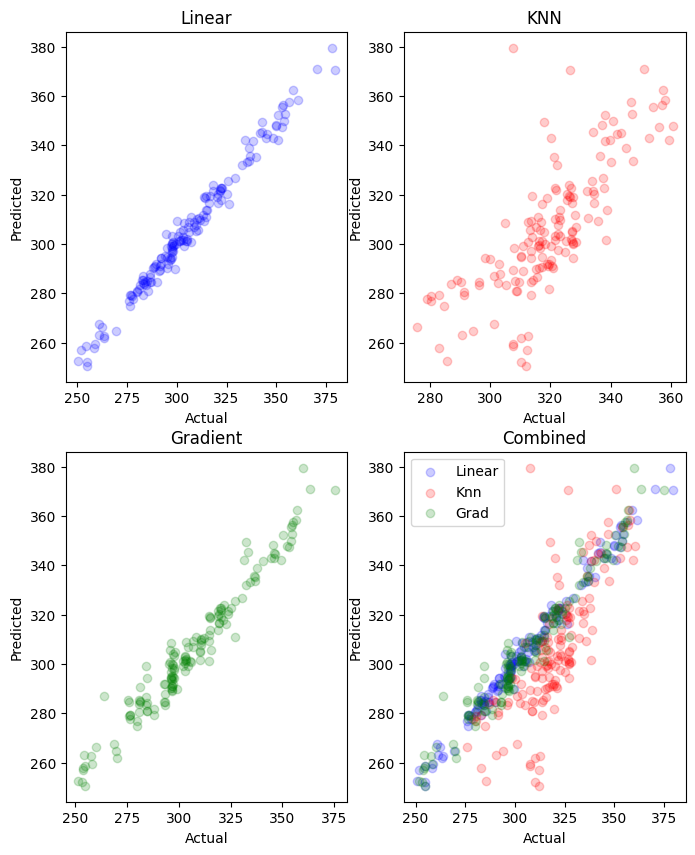

In [10]:

plt.figure(figsize=(8,10))

plt.subplot(2,2,1) 
plt.scatter(pred_linear, y_test, c='b', alpha=0.2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title("Linear")


plt.subplot(2,2,2) 
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.scatter(pred_knn, y_test, c='r', alpha=0.2)
plt.title("KNN")

plt.subplot(2,2,3) 
plt.scatter(pred_grad, y_test, c='g', alpha=0.2)

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title("Gradient")

plt.subplot(2,2,4)
plt.scatter(pred_linear, y_test, c='b', alpha=0.2)
plt.scatter(pred_knn, y_test, c='r', alpha=0.2)
plt.scatter(pred_grad, y_test, c='g', alpha=0.2)
plt.title("Combined")

plt.xlabel('Actual')
plt.ylabel('Predicted')

plt.legend(['Linear', 'Knn', 'Grad'])

plt.show()

#### Displaying some Stats

In [11]:
from sklearn.metrics import mean_absolute_percentage_error

knn_mape = mean_absolute_percentage_error(y_test, pred_knn)
linear_mape = mean_absolute_percentage_error(y_test, pred_linear)
grad_mape = mean_absolute_percentage_error(y_test, pred_grad)

df = {'Model': ['Linear','KNN', 'Grad'], 
               'MAPE': [linear_mape, knn_mape, grad_mape]
              }

pd.DataFrame(df)

,Model,MAPE
0,Linear,0.008611
1,KNN,0.059428
2,Grad,0.014297


Text(0, 0.5, 'MAPE (%)')

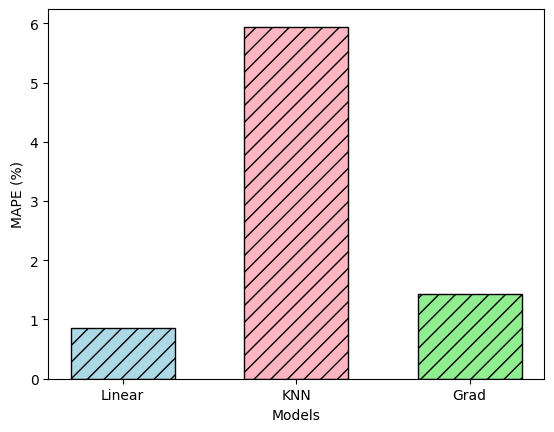

In [12]:
bars = plt.bar(['Linear','KNN', 'Grad'], [linear_mape*100, knn_mape*100, grad_mape*100],
       color=['#ADD8E6', '#FFB6C1', '#90EE90'], edgecolor='black', width=0.6)
for bar in bars:
    bar.set_hatch('//')

plt.xlabel("Models")
plt.ylabel("MAPE (%)")